In [40]:
import os
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import time

In [41]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows: 'Malgun Gothic', MacOS: 'AppleGothic', Linux: 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

In [42]:
# 네이버 API 키 설정
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

In [43]:
# KoBERT Fine-tuned 모델 로드
def load_sentiment_model():
    model_name = "beomi/kcbert-base"  # KoBERT 기반 공개 모델
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./model_cache")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=3, cache_dir="./model_cache"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

In [44]:
# 뉴스 데이터 수집 함수
def get_news_data(client_id, client_secret, query, display=10, start=1, sort='date'):
    enc_text = urllib.parse.quote(query)
    url = f"https://openapi.naver.com/v1/search/news?query={enc_text}&display={display}&start={start}&sort={sort}"
    
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    
    response = urllib.request.urlopen(request)
    rescode = response.getcode()
    
    if rescode == 200:
        response_body = response.read()
        response_json = json.loads(response_body)
        return pd.DataFrame(response_json['items'])
    else:
        print(f"Error Code: {rescode}")
        return pd.DataFrame()

In [45]:
# 날짜 필터링 함수
def filter_by_date(news_data, year):
    news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], errors='coerce')  # 날짜 형식으로 변환
    news_data = news_data.dropna(subset=['pubDate'])  # 유효한 날짜가 없는 데이터 제거
    news_data = news_data[news_data['pubDate'].dt.year == year]  # 특정 연도 필터링
    news_data['Date'] = news_data['pubDate'].dt.strftime('%Y-%m-%d')  # YYYY-MM-DD 형식 생성
    return news_data

In [46]:
# 배치 감정 분석 함수
def batch_analyze_sentiments(texts, tokenizer, model, device):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        max_length=300,  # 입력 텍스트를 300 토큰으로 제한
        padding=True
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    sentiments = torch.argmax(logits, dim=-1).tolist()
    sentiment_map = {0: "부정", 1: "중립", 2: "긍정"}
    return [sentiment_map[s] for s in sentiments]

In [47]:
# 시각화 함수
def plot_sentiment_distribution(sentiment_count, query):
    sentiment_count.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
    plt.title(f"뉴스 검색어 '{query}' 날짜별 감정 분석 결과")
    plt.xlabel("날짜")
    plt.ylabel("감정 건수")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [50]:
# 메인 함수
def main():
    query = "비트코인"
    display = 100  # 한 번에 가져올 뉴스 데이터 수
    num_requests = 3  # 가져올 페이지 수 (100개씩)
    year = 2024  # 필터링할 연도
    sort = "date"  # 날짜순 정렬

    # KoBERT 모델 로드
    tokenizer, model, device = load_sentiment_model()

    # 뉴스 데이터 수집
    result_all = pd.DataFrame()
    for i in range(num_requests):
        start = 1 + display * i
        result = get_news_data(client_id, client_secret, query, display, start, sort)
        result_all = pd.concat([result_all, result])
        time.sleep(1)  # API 호출 간 간격 추가
        result_all = pd.concat([result_all, result])
       
    # 날짜 필터링
    result_all = filter_by_date(result_all, year)

    if result_all.empty:
        print(f"{year}년의 뉴스 데이터가 없습니다.")
        return

    # 감정 분석 수행
    descriptions = result_all['description'].str.replace('<b>', '').str.replace('</b>', '').tolist()
    result_all['Sentiment'] = batch_analyze_sentiments(descriptions, tokenizer, model, device)

    # 날짜 및 감정별 집계
    sentiment_count = result_all.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

    # 결과 출력
    print(sentiment_count)

    # 그래프 생성
    plot_sentiment_distribution(sentiment_count, query)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment   긍정  부정   중립
Date                   
2024-12-06  68   2  130
2024-12-07  82   4  140
2024-12-08  62   4  108


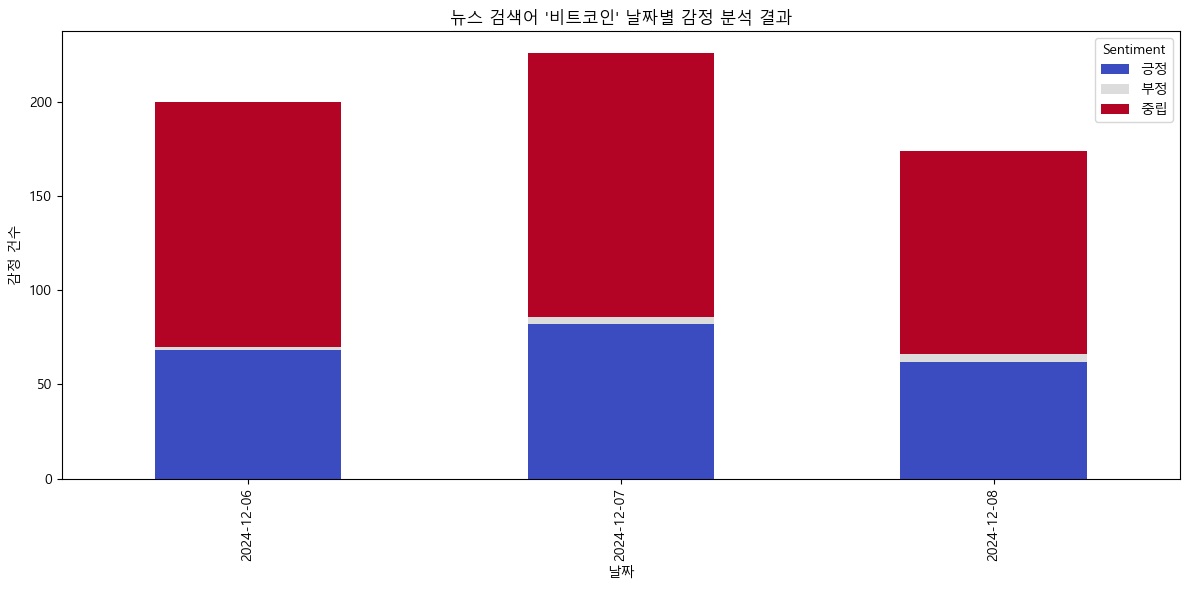

In [51]:
if __name__ == "__main__":
    main()